### IMPORT PACKAGE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append('./src/analysis')
sys.path.append('./src/data_handling')
sys.path.append('./src/modeling')
sys.path.append('./src/prediction')
sys.path.append('./src/visualization')


In [2]:
from analyzer import FeatureAnalyzer
from selector import FeatureSelector
from aggregator import DataAggregator
from feature_engineer import BatteryFeatureEngineer
from reader import BatteryDataReader
from cross_validator import CrossValidator
from evaluator import ModelEvaluator
from trainer import ModelTrainer
from predictor import Predictor
from visualizer import ResultVisualizer


# Aggregation all data --> One dataFrame for model

In [3]:
battery_ids = ['B0005', 'B0006', 'B0007', 'B0018']
ACTUAL_DATA_DIR = "./dataset/"

# Update config for feature engineering
fe_configuration = {
    # Update config
}

# Init object
aggregator_df = DataAggregator(
    battery_ids=battery_ids,
    data_dir=ACTUAL_DATA_DIR,
    fe_config=fe_configuration
)



In [4]:
# Aggregator data
aggregator_df.aggregate(force_rerun=True)

# Get data aggregator
df_combined = aggregator_df.get_combined_data()

# Check data combined
df_combined.head()


--- Starting Data Aggregation for Batteries: ['B0006', 'B0018', 'B0005', 'B0007'] ---


Aggregating Batteries:   0%|          | 0/4 [00:00<?, ?it/s]


--- Processing: B0006 ---
--- Loading data for battery: B0006 ---
  Successfully loaded: capacity_B0006.csv
  Successfully loaded: charge_B0006.csv
  Successfully loaded: discharge_B0006.csv
--- Data loading process completed for B0006 ---
  Ensuring numeric types for B0006...
--- Starting Feature Engineering process for B0006 ---
  Calculating SOH/RUL for B0006...
  Engineering discharge features for B0006...


  Engineering charge features for B0006...


Aggregating Batteries:  25%|██▌       | 1/4 [00:00<00:02,  1.47it/s]

  Merging features for B0006...
  Handling NaNs for B0006...
--- Feature Engineering process finished for B0006 ---
  Successfully processed B0006. Shape: (168, 13)

--- Processing: B0018 ---
--- Loading data for battery: B0018 ---
  Successfully loaded: capacity_B0018.csv
  Successfully loaded: charge_B0018.csv
  Successfully loaded: discharge_B0018.csv
--- Data loading process completed for B0018 ---
  Ensuring numeric types for B0018...
--- Starting Feature Engineering process for B0018 ---
  Calculating SOH/RUL for B0018...
    Note: Battery B0018 did not reach EoL threshold (1.30 Ah). Using 133 for RUL.
  Engineering discharge features for B0018...


  Engineering charge features for B0018...


Aggregating Batteries:  50%|█████     | 2/4 [00:01<00:01,  1.76it/s]

  Merging features for B0018...
  Handling NaNs for B0018...
--- Feature Engineering process finished for B0018 ---
  Successfully processed B0018. Shape: (132, 13)

--- Processing: B0005 ---
--- Loading data for battery: B0005 ---
  Successfully loaded: capacity_B0005.csv
  Successfully loaded: charge_B0005.csv
  Successfully loaded: discharge_B0005.csv
--- Data loading process completed for B0005 ---
  Ensuring numeric types for B0005...
--- Starting Feature Engineering process for B0005 ---
  Calculating SOH/RUL for B0005...
  Engineering discharge features for B0005...


  Engineering charge features for B0005...


Aggregating Batteries:  75%|███████▌  | 3/4 [00:01<00:00,  1.64it/s]

  Merging features for B0005...
  Handling NaNs for B0005...
--- Feature Engineering process finished for B0005 ---
  Successfully processed B0005. Shape: (168, 13)

--- Processing: B0007 ---
--- Loading data for battery: B0007 ---
  Successfully loaded: capacity_B0007.csv
  Successfully loaded: charge_B0007.csv
  Successfully loaded: discharge_B0007.csv
--- Data loading process completed for B0007 ---
  Ensuring numeric types for B0007...
--- Starting Feature Engineering process for B0007 ---
  Calculating SOH/RUL for B0007...
    Note: Battery B0007 did not reach EoL threshold (1.32 Ah). Using 169 for RUL.
  Engineering discharge features for B0007...


  Engineering charge features for B0007...


Aggregating Batteries: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

  Merging features for B0007...
  Handling NaNs for B0007...
--- Feature Engineering process finished for B0007 ---
  Successfully processed B0007. Shape: (168, 13)

--- Concatenating data from all processed batteries ---
Combined DataFrame shape: (636, 13)
Unique batteries in combined data: ['B0006' 'B0018' 'B0005' 'B0007']

--- Performing final NaN check and fill on combined data ---
No NaNs found in the combined data after individual processing.
--- Data Aggregation Finished ---


,cycle,capacity,SOH,RUL,Discharge_V_median,Discharge_V_skew,Discharge_T_delta,Discharge_T_std,Charge_T_std,Time_CC_phase,Time_CV_phase,CV_I_end,battery_id
0,1,2.035338,100.000000,101,3.548989,-1.019780,14.885913,3.460482,0.985631,439.438,6739.937,-0.004522,B0006
1,2,2.025140,99.498985,100,3.554208,-1.295688,14.607964,3.404115,1.710039,3224.844,6792.750,-0.001965,B0006
2,3,2.013326,98.918547,99,3.556400,-1.061351,14.295145,3.358434,1.758008,3221.765,6765.344,-0.003012,B0006
3,4,2.013285,98.916498,98,3.557417,-0.971438,14.195243,3.349620,1.752708,3189.625,6713.781,0.001331,B0006
4,5,2.000528,98.289755,97,3.556609,-1.415468,14.343783,3.344364,1.772646,3166.015,6849.922,0.018652,B0006


# PROCESS OUTLIER: Time_CV_phase, Time_CC_phase, Charge_T_std

In [5]:
def replace_outlier(df_processed,column_names, thresholds):
    for column_name, threshold in zip(column_names, thresholds):
        indices_below_threshold = df_processed.index[df_processed[column_name] < threshold].tolist()

        print(f"\nCác index có giá trị < {threshold}: {indices_below_threshold}")

        for idx in indices_below_threshold:
            # Kiểm tra xem có phải là hàng cuối cùng không
            if idx < len(df_processed) - 1:
                value_after = df_processed.loc[idx + 1, column_name]
                print(f" - Tại index {idx}, giá trị gốc là {df_processed.loc[idx, column_name]}.Thay bằng : {value_after}")
                df_processed.loc[idx, column_name] = value_after
        

In [7]:
df_combined_copy = df_combined.copy()

In [10]:
replace_outlier(df_combined_copy, ['Time_CV_phase', 'Time_CC_phase', 'Charge_T_std'],[6000, 500, 0.7])


Các index có giá trị < 6000: []

Các index có giá trị < 500: []

Các index có giá trị < 0.7: []


# NORMALIZATION

In [11]:
df_combined_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636 entries, 0 to 635
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cycle               636 non-null    int64  
 1   capacity            636 non-null    float64
 2   SOH                 636 non-null    float64
 3   RUL                 636 non-null    int64  
 4   Discharge_V_median  636 non-null    float64
 5   Discharge_V_skew    636 non-null    float64
 6   Discharge_T_delta   636 non-null    float64
 7   Discharge_T_std     636 non-null    float64
 8   Charge_T_std        636 non-null    float64
 9   Time_CC_phase       636 non-null    float64
 10  Time_CV_phase       636 non-null    float64
 11  CV_I_end            636 non-null    float64
 12  battery_id          636 non-null    object 
dtypes: float64(10), int64(2), object(1)
memory usage: 64.7+ KB


In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [13]:
features_to_scale = ['Discharge_V_median', 'Discharge_V_skew','Discharge_T_delta','Discharge_T_std','Charge_T_std','Time_CC_phase'
                    ,'Time_CV_phase']
df_scaled = df_combined_copy.copy()
# --- A. StandardScaler ---
print("\n--- Sử dụng StandardScaler ---")
scaler_std = StandardScaler()
# Fit và transform trực tiếp trên các cột đã chọn của df_scaled
df_scaled[features_to_scale] = scaler_std.fit_transform(df_scaled[features_to_scale])
print("DataFrame sau khi chuẩn hóa bằng StandardScaler:")
print(df_scaled)
# In ra mean và std của các cột đã chuẩn hóa để kiểm tra
print("Mô tả thống kê các cột đã chuẩn hóa (StandardScaler):")
print(df_scaled[features_to_scale].describe().round(2)) # Mean gần 0, std gần 1


--- Sử dụng StandardScaler ---
DataFrame sau khi chuẩn hóa bằng StandardScaler:
     cycle  capacity         SOH  RUL  Discharge_V_median  Discharge_V_skew  \
0        1  2.035338  100.000000  101            1.191649         -0.568710   
1        2  2.025140   99.498985  100            1.309606         -1.235678   
2        3  2.013326   98.918547   99            1.359164         -0.669202   
3        4  2.013285   98.916498   98            1.382149         -0.451848   
4        5  2.000528   98.289755   97            1.363899         -1.525228   
..     ...       ...         ...  ...                 ...               ...   
631    164  1.406171   74.359204    5           -0.736772         -0.394407   
632    165  1.406336   74.367898    4           -0.761215         -0.808624   
633    166  1.400455   74.056928    3           -0.776627         -0.300212   
634    167  1.421787   75.184938    2           -0.582331         -0.946079   
635    168  1.432455   75.749109    1           -0

# ANALYSIS DATA 

FeatureAnalyzer initialized with data shape: (636, 13)
Correlation matrix not calculated yet. Calculating with default settings...

Calculating correlation matrix (method='pearson', numeric_only=True)...
  Using 12 numeric columns for correlation.
  Correlation matrix calculated successfully.

Plotting correlation heatmap...


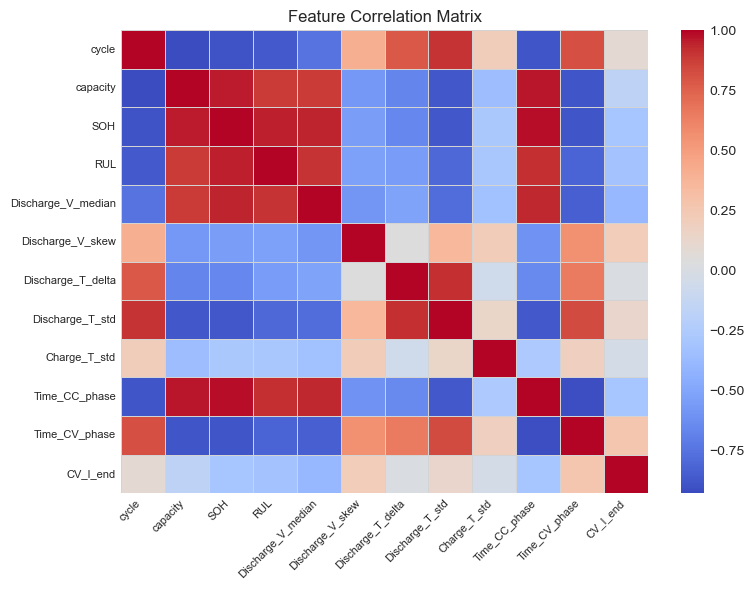

In [14]:
# Init object analyzer
analyzer = FeatureAnalyzer(combined_data=df_scaled)

# Plot heatmap
analyzer.plot_correlation_heatmap(figsize=(8, 6), annot=False)


Top 5 Positive/Negative:
Time_CC_phase         0.979121
capacity              0.958613
RUL                   0.948663
Discharge_V_median    0.943803
Charge_T_std         -0.279624
Name: SOH, dtype: float64
Discharge_V_skew    -0.551892
Discharge_T_delta   -0.659147
Discharge_T_std     -0.877038
Time_CV_phase       -0.888345
cycle               -0.894295
Name: SOH, dtype: float64

Plotting correlation with target: 'SOH'...


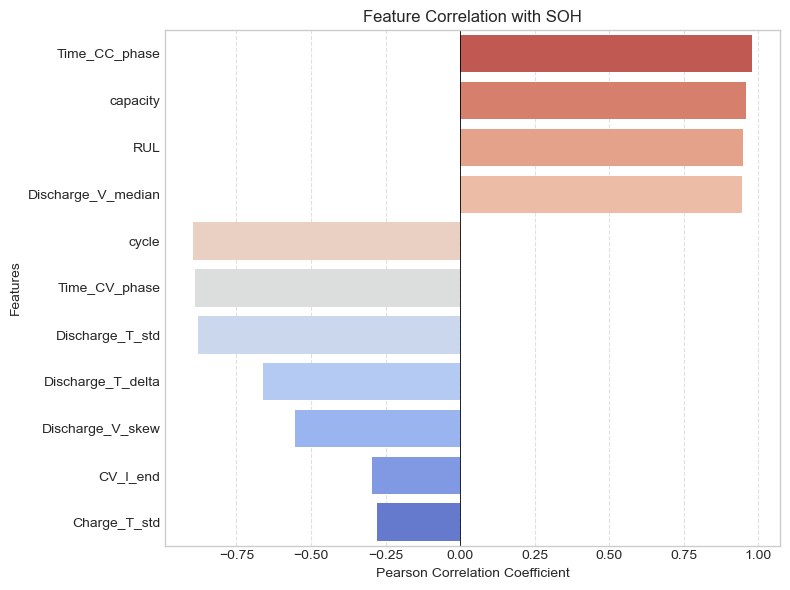

In [15]:
# Get correlation value with SOH and RUL
soh_correlation = analyzer.get_correlation_with_target('SOH')

print("Top 5 Positive/Negative:")
print(soh_correlation.drop('SOH', errors='ignore').head())
print(soh_correlation.drop('SOH', errors='ignore').tail())
analyzer.plot_correlation_with_target('SOH', sort_by_abs=True, figsize=(8,6))




# BASE MODEL

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (
    LeaveOneGroupOut, GridSearchCV, GroupKFold, KFold
)
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C_kernel, WhiteKernel
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.base import clone
import matplotlib.pyplot as plt
import warnings
import time

warnings.filterwarnings('ignore')

In [17]:
target_column = 'SOH'
group_column = 'battery_id'
cycle_plot_column = 'cycle'

In [18]:
feature_columns= ['Discharge_V_median', 'Discharge_T_std', 'Charge_T_std', 'Time_CC_phase']

In [19]:
X = df_scaled[feature_columns]
y = df_scaled[target_column]
groups = df_scaled[group_column]

In [20]:
rf_model = RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1, max_depth=12, min_samples_split=5, min_samples_leaf=3)
xgb_model = XGBRegressor(n_estimators=150, random_state=42, n_jobs=-1, objective='reg:squarederror', learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8)
svr_model = SVR(kernel='rbf', C=15, epsilon=0.01, gamma='auto') # gamma='auto' or 'scale' or a float
gpr_kernel_tuned = C_kernel(1.0, (1e-3, 1e3)) * RBF(length_scale=np.ones(len(feature_columns)), length_scale_bounds=(1e-2, 1e2)) + \
                   WhiteKernel(noise_level=0.05, noise_level_bounds=(1e-10, 1e+1))
# Chú ý: length_scale cho RBF trong GPR có thể là một vector (mỗi chiều một length_scale) hoặc một scalar.
# Nếu là vector, kích thước phải bằng số lượng features.
gpr_model = GaussianProcessRegressor(kernel=gpr_kernel_tuned, random_state=42,
                                     alpha=1e-6, # Tham số nhiễu, có thể điều chỉnh
                                     n_restarts_optimizer=10, # Để GPR tìm kernel tốt hơn
                                     normalize_y=False) # Xem xét normalize_y=True nếu SOH có thang đo rộng

base_learners_defs = [
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('svr', svr_model),
    ('gpr', gpr_model)
]



In [25]:
logo = LeaveOneGroupOut()
n_splits = logo.get_n_splits(groups=groups)

oof_predictions_base = np.zeros((len(X), len(base_learners_defs)))
oof_true_targets_for_meta = np.zeros(len(X)) # Đổi tên để rõ ràng hơn

# Tạo một DataFrame để lưu trữ các chỉ số đánh giá của base learners trên từng fold
base_learner_metrics_per_fold = []

print(f"\nBắt đầu quá trình LOBO với {n_splits} pin...")

for fold_idx, (train_idx, val_idx) in enumerate(logo.split(X, y, groups)):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    current_val_battery_id = groups.iloc[val_idx].unique()[0]

    print(f"  Fold {fold_idx + 1}/{n_splits} - Pin đang được bỏ ra để validation: {current_val_battery_id}")
    oof_true_targets_for_meta[val_idx] = y_val_fold.values

    for i, (name, model_template) in enumerate(base_learners_defs):
        print(f"    Đang huấn luyện base learner: {name} cho pin {current_val_battery_id}")
        model_instance = clone(model_template)
        fold_preds = np.full(len(X_val_fold), np.nan) # Khởi tạo dự đoán là NaN
        r2 = np.nan
        mae = np.nan
        rmse = np.nan

        try:
            if X_train_fold.empty and name == 'gpr':
                 raise ValueError("X_train_fold rỗng, không thể huấn luyện GPR")
            model_instance.fit(X_train_fold, y_train_fold)
            fold_preds_success = model_instance.predict(X_val_fold)
            fold_preds = fold_preds_success # Gán lại nếu thành công

            # Tính toán các chỉ số nếu dự đoán thành công
            r2 = r2_score(y_val_fold, fold_preds)
            mae = mean_absolute_error(y_val_fold, fold_preds)
            rmse = np.sqrt(mean_squared_error(y_val_fold, fold_preds))

            print(f"      {name} - Pin {current_val_battery_id}: R2={r2:.4f}, MAE={mae:.4f}, RMSE={rmse:.4f}")

        except Exception as e:
            print(f"    LỖI khi huấn luyện/dự đoán với {name}: {e}")
            # fold_preds đã được khởi tạo là NaN, các metrics cũng là NaN

        oof_predictions_base[val_idx, i] = fold_preds
        base_learner_metrics_per_fold.append({
            'fold': fold_idx + 1,
            'battery_id_val': current_val_battery_id,
            'base_learner': name,
            'R2': r2,
            'MAE': mae,
            'RMSE': rmse
        })

print("\nHoàn thành tạo OOF predictions cho base learners.")

# Chuyển danh sách metrics thành DataFrame để dễ xem và phân tích
metrics_df = pd.DataFrame(base_learner_metrics_per_fold)
print("\n--- Chỉ số đánh giá của Base Learners trên từng Fold (LOBO) ---")
print(metrics_df)

# Tính trung bình các chỉ số cho mỗi base learner qua các fold
print("\n--- Chỉ số đánh giá trung bình của Base Learners qua các Folds ---")
avg_metrics_df = metrics_df.groupby('base_learner')[['R2', 'MAE', 'RMSE']].mean()
print(avg_metrics_df)


meta_features_from_oof = pd.DataFrame(oof_predictions_base, columns=[name for name, _ in base_learners_defs])
for col in meta_features_from_oof.columns:
    if meta_features_from_oof[col].isnull().any():
        print(f"Cảnh báo: Tìm thấy NaN trong OOF predictions của {col}. Điền bằng giá trị trung bình.")
        if not meta_features_from_oof[col].isnull().all():
            mean_val = meta_features_from_oof[col].mean()
            meta_features_from_oof[col].fillna(mean_val, inplace=True)
        else:
            print(f"Cảnh báo: Tất cả giá trị trong OOF predictions của {col} là NaN. Điền bằng 0.")
            meta_features_from_oof[col].fillna(0, inplace=True)

meta_target_for_training = pd.Series(oof_true_targets_for_meta, name=target_column) # Sử dụng tên đã đổi



Bắt đầu quá trình LOBO với 4 pin...
  Fold 1/4 - Pin đang được bỏ ra để validation: B0005
    Đang huấn luyện base learner: rf cho pin B0005
      rf - Pin B0005: R2=0.9209, MAE=2.4096, RMSE=2.8758
    Đang huấn luyện base learner: xgb cho pin B0005
      xgb - Pin B0005: R2=0.9220, MAE=2.3945, RMSE=2.8564
    Đang huấn luyện base learner: svr cho pin B0005
      svr - Pin B0005: R2=0.9504, MAE=1.7974, RMSE=2.2764
    Đang huấn luyện base learner: gpr cho pin B0005
      gpr - Pin B0005: R2=0.9108, MAE=2.2480, RMSE=3.0535
  Fold 2/4 - Pin đang được bỏ ra để validation: B0006
    Đang huấn luyện base learner: rf cho pin B0006
      rf - Pin B0006: R2=0.8051, MAE=4.2219, RMSE=5.4501
    Đang huấn luyện base learner: xgb cho pin B0006
      xgb - Pin B0006: R2=0.7598, MAE=4.5337, RMSE=6.0506
    Đang huấn luyện base learner: svr cho pin B0006
      svr - Pin B0006: R2=0.7395, MAE=4.6956, RMSE=6.3010
    Đang huấn luyện base learner: gpr cho pin B0006
      gpr - Pin B0006: R2=0.7047, MAE

In [28]:
meta_features_from_oof.head(10)

,rf,xgb,svr,gpr
0,92.194848,93.751877,91.567688,98.942341
1,93.224818,93.412331,93.653407,97.639135
2,93.226922,94.548561,94.114095,95.789206
3,93.322875,94.510292,93.989391,94.885128
4,93.322875,94.622269,94.503118,95.257396
5,95.806021,97.059509,95.650261,96.683702
6,95.613442,97.106674,95.884539,96.341686
7,92.365779,93.222748,93.341512,90.729224
8,92.536035,93.554947,93.689762,90.885602
9,92.552898,93.584930,93.849914,91.105856


# META MODEL


Đang huấn luyện meta-learner (Ridge Regression)...
Hoàn thành huấn luyện meta-learner.

Hệ số của meta-learner (Ridge Regression):
  rf: 0.3167
  xgb: 0.1619
  svr: 0.3469
  gpr: 0.2944

--- Chỉ số đánh giá của Mô hình STACKING trên OOF predictions (tổng thể) ---
  RMSE: 2.8223
  R2 score: 0.9332
  MAE: 2.1469


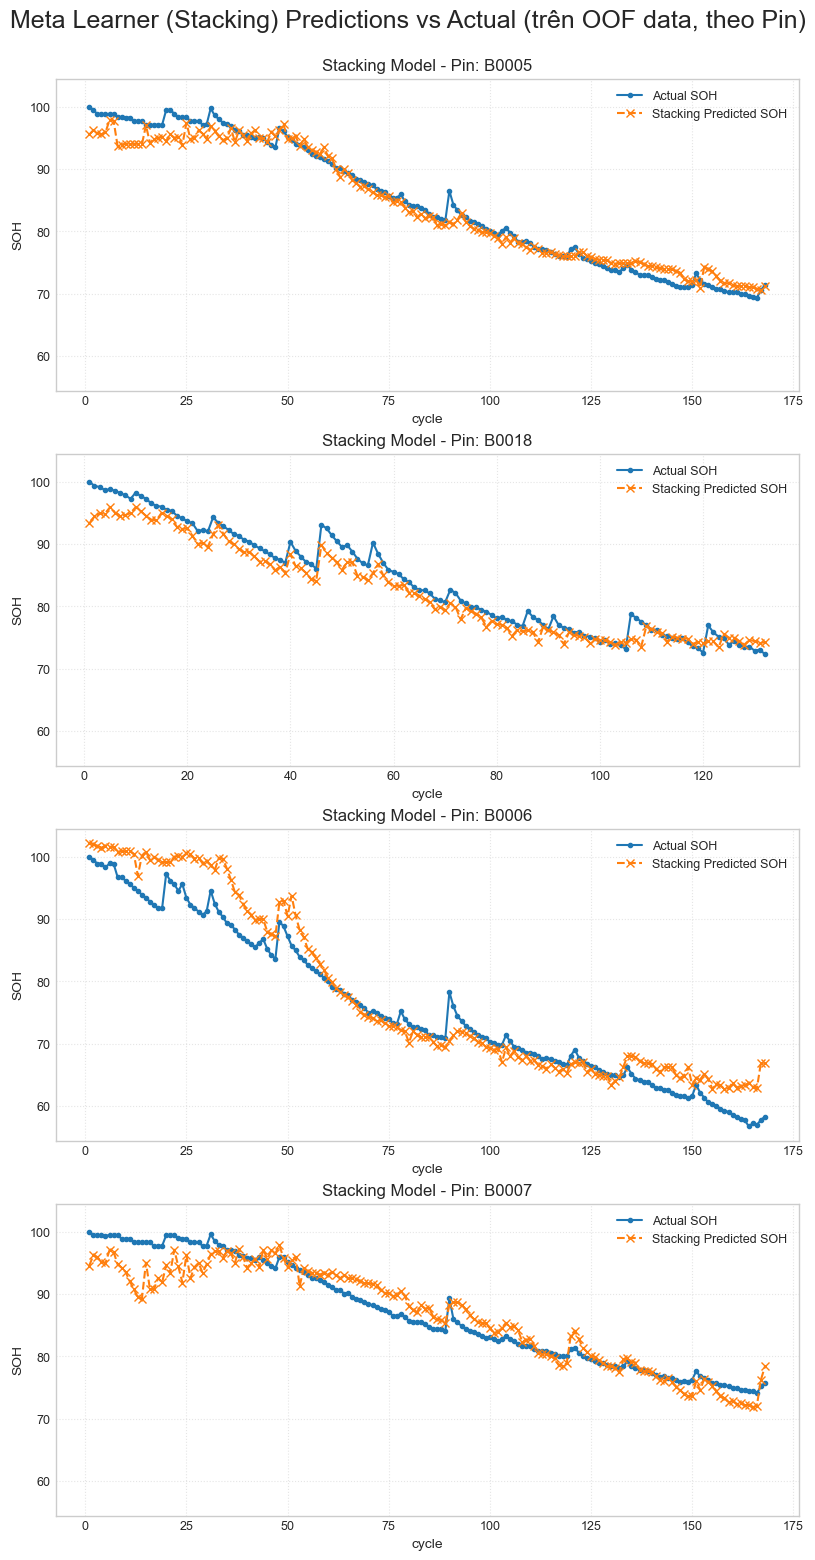

In [67]:
meta_learner_ridge_template = Ridge(alpha=0.5, random_state=42, solver='auto')
trained_meta_learner = clone(meta_learner_ridge_template)

print("\nĐang huấn luyện meta-learner (Ridge Regression)...")
trained_meta_learner.fit(meta_features_from_oof, meta_target_for_training)
print("Hoàn thành huấn luyện meta-learner.")
print("\nHệ số của meta-learner (Ridge Regression):")
for name, coef in zip(meta_features_from_oof.columns, trained_meta_learner.coef_):
    print(f"  {name}: {coef:.4f}")

# --- BƯỚC 4: ĐÁNH GIÁ VÀ VẼ ĐỒ THỊ CHO META-LEARNER TRÊN OOF PREDICTIONS ---
stacking_oof_predictions = trained_meta_learner.predict(meta_features_from_oof)
oof_rmse_stacking = np.sqrt(mean_squared_error(meta_target_for_training, stacking_oof_predictions))
oof_r2_stacking = r2_score(meta_target_for_training, stacking_oof_predictions)
oof_mae_stacking = mean_absolute_error(meta_target_for_training, stacking_oof_predictions) # Thêm MAE cho stacking
print(f"\n--- Chỉ số đánh giá của Mô hình STACKING trên OOF predictions (tổng thể) ---")
print(f"  RMSE: {oof_rmse_stacking:.4f}")
print(f"  R2 score: {oof_r2_stacking:.4f}")
print(f"  MAE: {oof_mae_stacking:.4f}")


# Vẽ đồ thị cho meta-learner (giữ nguyên phần này vì nó hữu ích)
fig_meta_learner, axes_meta_learner = plt.subplots(n_splits, 1,
                                                   figsize=(8, 15),
                                                   sharey=True, constrained_layout=True)
if n_splits == 1:
    axes_meta_learner = [axes_meta_learner]
fig_meta_learner.suptitle('Meta Learner (Stacking) Predictions vs Actual (trên OOF data, theo Pin)', fontsize=18, y=1.03)
unique_batteries = groups.unique()
for i, battery_id_to_plot in enumerate(unique_batteries):
    battery_mask = (groups == battery_id_to_plot).values
    x_plot_values_batt = df_scaled[battery_mask][cycle_plot_column].values
    actual_batt = meta_target_for_training[battery_mask]
    predicted_batt_stacking = stacking_oof_predictions[battery_mask]
    ax_meta = axes_meta_learner[i]
    ax_meta.plot(x_plot_values_batt, actual_batt, label='Actual SOH', marker='.', linestyle='-', markersize=6)
    ax_meta.plot(x_plot_values_batt, predicted_batt_stacking, label='Stacking Predicted SOH', marker='x', linestyle='--', markersize=6)
    ax_meta.set_title(f'Stacking Model - Pin: {battery_id_to_plot}', fontsize=12)
    ax_meta.set_xlabel(cycle_plot_column, fontsize=10)
    ax_meta.set_ylabel('SOH', fontsize=10)
    ax_meta.legend(fontsize=9)
    ax_meta.grid(True, linestyle=':', alpha=0.5)
    ax_meta.tick_params(axis='both', which='major', labelsize=9)

In [ ]:
# --- BƯỚC 5: XÂY DỰNG MÔ HÌNH STACKING CUỐI CÙNG ĐỂ DỰ ĐOÁN TRÊN DỮ LIỆU MỚI ---
# (Class FinalStackingRegressor giữ nguyên như trước)
class FinalStackingRegressor:
    def __init__(self, base_learner_templates_list, meta_learner_template_model):
        self.base_learner_templates_list = base_learner_templates_list
        self.meta_learner_template_model = meta_learner_template_model
        self.trained_base_learners_ = []
        self.trained_meta_learner_ = None
        self.active_base_learner_names_ = []

    def fit(self, X_all_train_data, y_all_train_data, X_meta_features_oof_data, y_meta_target_oof_data):
        print("Đang huấn luyện lại các base learner trên TOÀN BỘ dữ liệu huấn luyện gốc...")
        self.trained_base_learners_ = []
        self.active_base_learner_names_ = []
        for name, model_template_item in self.base_learner_templates_list:
            print(f"  Huấn luyện {name}...")
            model_instance_item = clone(model_template_item)
            try:
                if X_all_train_data.empty and name == 'gpr':
                    raise ValueError("X_all_train_data rỗng, không thể huấn luyện GPR")
                model_instance_item.fit(X_all_train_data, y_all_train_data)
                self.trained_base_learners_.append(model_instance_item)
                self.active_base_learner_names_.append(name)
            except Exception as e:
                print(f"    LỖI khi huấn luyện lại {name} trên toàn bộ dữ liệu: {e}. Base learner này sẽ bị bỏ qua.")
        print(f"Hoàn thành huấn luyện {len(self.trained_base_learners_)} base learners.")

        print("\nĐang huấn luyện meta-learner trên dữ liệu OOF...")
        self.trained_meta_learner_ = clone(self.meta_learner_template_model)
        self.trained_meta_learner_.fit(X_meta_features_oof_data, y_meta_target_oof_data)
        print("Hoàn thành huấn luyện meta-learner.")
        return self

    def predict(self, X_new_data):
        if not self.trained_base_learners_ or self.trained_meta_learner_ is None:
            raise ValueError("Mô hình Stacking chưa được huấn luyện đầy đủ. Gọi fit() trước.")
        if not self.active_base_learner_names_:
             raise ValueError("Không có base learner nào được huấn luyện thành công trong mô hình cuối cùng.")

        print("Tạo dự đoán từ các base learner cho dữ liệu mới...")
        base_predictions_new_data = np.zeros((len(X_new_data), len(self.trained_base_learners_)))
        for i, model_instance_item in enumerate(self.trained_base_learners_):
            base_predictions_new_data[:, i] = model_instance_item.predict(X_new_data)
        meta_features_new_data = pd.DataFrame(base_predictions_new_data, columns=self.active_base_learner_names_)

        print("Tạo dự đoán cuối cùng từ meta-learner...")
        final_predictions_result = self.trained_meta_learner_.predict(meta_features_new_data)
        return final_predictions_result

final_stacking_model_instance = FinalStackingRegressor(
    base_learner_templates_list=base_learners_defs,
    meta_learner_template_model=meta_learner_ridge_template
)
final_stacking_model_instance.fit(
    X_all_train_data=X, y_all_train_data=y,
    X_meta_features_oof_data=meta_features_from_oof, y_meta_target_oof_data=meta_target_for_training
)

# ---- GIẢ LẬP DỮ LIỆU TEST MỚI ĐỂ DỰ ĐOÁN VÀ VẼ ĐỒ THỊ ----
n_test_samples = 50
X_test_new_demo = pd.DataFrame(np.random.normal(0, 0.5, (n_test_samples, len(feature_columns))), columns=feature_columns)
test_cycles_original = np.arange(1, n_test_samples + 1)
y_test_actual_demo = 1 - (test_cycles_original / (n_test_samples * 1.8)) - np.random.normal(0, 0.02, n_test_samples)
y_test_actual_demo = np.clip(y_test_actual_demo, 0.65, 1.0)
X_test_new_demo[cycle_plot_column] = test_cycles_original

predictions_on_new_data = final_stacking_model_instance.predict(X_test_new_demo[feature_columns])

# Đánh giá trên tập test mới (nếu có y_test_actual_demo)
test_rmse = np.sqrt(mean_squared_error(y_test_actual_demo, predictions_on_new_data))
test_r2 = r2_score(y_test_actual_demo, predictions_on_new_data)
test_mae = mean_absolute_error(y_test_actual_demo, predictions_on_new_data)
print(f"\n--- Chỉ số đánh giá của Mô hình STACKING trên DỮ LIỆU TEST MỚI ---")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R2 score: {test_r2:.4f}")
print(f"  MAE: {test_mae:.4f}")

# Vẽ đồ thị cho dữ liệu test (giữ nguyên)
fig_test, ax_test = plt.subplots(figsize=(12, 7))
ax_test.plot(X_test_new_demo[cycle_plot_column], y_test_actual_demo, label='Actual SOH (Test Data)', marker='.', linestyle='-', markersize=7)
ax_test.plot(X_test_new_demo[cycle_plot_column], predictions_on_new_data, label='Stacking Predicted SOH (Test Data)', marker='x', linestyle='--', markersize=7)
ax_test.set_title('Stacking Model Predictions vs Actual on New Test Data', fontsize=14)
ax_test.set_xlabel(cycle_plot_column, fontsize=12)
ax_test.set_ylabel('SOH', fontsize=12)
ax_test.legend(fontsize=10)
ax_test.grid(True, linestyle=':', alpha=0.6)
ax_test.tick_params(axis='both', which='major', labelsize=10)

plt.show()

# Tối ưu hóa tham số mô hình

In [21]:
# --- Định nghĩa các nhóm/cấp độ siêu tham số cho từng base learner ---

param_levels = {
    'rf': {
        'simple': {
            'n_estimators': [100],
            'max_depth': [5, 10],
            'min_samples_split': [10],
            'min_samples_leaf': [5],
            'max_features': ['sqrt']
        },
        'moderate': {
            'n_estimators': [150, 200],
            'max_depth': [10, 15], # None cho phép cây phát triển đầy đủ
            'min_samples_split': [5, 10],
            'min_samples_leaf': [2, 4],
            'max_features': ['sqrt']
        },
        'complex': {
            'n_estimators': [200, 300],
            'max_depth': [15, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'max_features': ['sqrt'] # Thử cả tỷ lệ feature
        },
        'very_complex': {
            'n_estimators': [300, 500],
            'max_depth': [20, 30],
            'min_samples_split': [2],
            'min_samples_leaf': [1],
            'max_features': ['sqrt'] # 'auto' = all features
        }
    },
    'xgb': {
        'simple': {
            'n_estimators': [100],
            'learning_rate': [0.1],
            'max_depth': [3, 5],
            'subsample': [0.8],
            'colsample_bytree': [0.8],
            'gamma': [0, 0.1]
        },
        'moderate': {
            'n_estimators': [150, 200],
            'learning_rate': [0.05],
            'max_depth': [5, 7],
            'subsample': [0.7, 0.8],
            'colsample_bytree': [0.7, 0.8],
            'gamma': [0, 0.1],
            'reg_alpha': [0, 0.01],
            'reg_lambda': [1, 0.1] # Lambda thường > Alpha
        },
        'complex': {
            'n_estimators': [200, 300],
            'learning_rate': [0.01], # Learning rate nhỏ hơn với nhiều cây hơn
            'max_depth': [7, 9],
            'subsample': [0.6, 0.7],
            'colsample_bytree': [0.6, 0.7],
            'gamma': [0.1, 0.2],
            'reg_alpha': [0.01, 0.1],
            'reg_lambda': [0.1, 0.5]
        },
        'very_complex': {
            'n_estimators': [300, 500],
            'learning_rate': [0.01],
            'max_depth': [9, 12],
            'subsample': [0.5, 0.6],
            'colsample_bytree': [0.5, 0.6],
            'gamma': [0.2, 0.5],
            'reg_alpha': [0.1, 0.5],
            'reg_lambda': [0.5, 1]
        }
    },
    'svr': {
        'simple': {
            'C': [1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale'], # 'scale' là lựa chọn an toàn
            'epsilon': [0.1]
        },
        'moderate': {
            'C': [10, 50],
            'kernel': ['rbf', 'poly'],
            'gamma': ['scale', 'auto', 0.01],
            'epsilon': [0.05, 0.1],
            'degree': [2, 3] # Cho poly
        },
        'complex': {
            'C': [50, 100],
            'kernel': ['rbf', 'poly'],
            'gamma': [0.001, 0.01, 0.1], # Giá trị gamma cụ thể
            'epsilon': [0.01, 0.05],
            'degree': [3, 4]
        },
        'very_complex': {
            'C': [100, 200],
            'kernel': ['rbf'], # RBF thường linh hoạt nhất
            'gamma': [0.0001, 0.001, 0.01],
            'epsilon': [0.005, 0.01],
            # 'degree' không cần nếu chỉ dùng RBF
        }
    },
    'gpr': {
        # Tinh chỉnh GPR kernel phức tạp hơn, cần định nghĩa các kernel ứng viên
        # Ở đây, chúng ta sẽ tập trung vào các tham số alpha và n_restarts
        # và giả sử bạn sẽ định nghĩa một vài kernel candidates riêng
        'simple': {
            # 'kernel': [kernel_simple_1, kernel_simple_2], # Bạn cần định nghĩa các kernel này
            'alpha': [1e-5, 1e-3],
            'n_restarts_optimizer': [5]
        },
        'moderate': {
            # 'kernel': [kernel_moderate_1, kernel_moderate_2],
            'alpha': [1e-7, 1e-5],
            'n_restarts_optimizer': [10]
        },
        'complex': {
            # 'kernel': [kernel_complex_1, kernel_complex_2],
            'alpha': [1e-9, 1e-7],
            'n_restarts_optimizer': [15]
        },
        'very_complex': {
            # 'kernel': [kernel_very_complex_1, kernel_very_complex_2],
            'alpha': [1e-10, 1e-9],
            'n_restarts_optimizer': [20]
        }
    },
    'ridge': { # Siêu tham số cho Meta-Learner (Ridge Regression)
        'simple': {'alpha': [1.0, 5.0, 10.0]},
        'moderate': {'alpha': [0.1, 0.5, 1.0, 2.0]},
        'complex': {'alpha': [0.01, 0.05, 0.1, 0.5]}, # Alpha nhỏ hơn cho phép phức tạp hơn
        'very_complex': {'alpha': [0.001, 0.005, 0.01, 0.05]}
    }
}


In [22]:
# --- Cấp độ 'simple' ---
num_features = 7
from sklearn.gaussian_process.kernels import (
    RBF,
    Matern,
    RationalQuadratic,
    ExpSineSquared,
    DotProduct,
    ConstantKernel as C, # Đổi tên để tránh nhầm lẫn với hằng số C của SVR
    WhiteKernel,
    PairwiseKernel # Cho phép sử dụng các kernel của scikit-learn như linear, rbf, poly
)
# Kernel RBF đơn giản với length_scale vô hướng (isotropic)
kernel_gpr_simple_rbf = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + \
                        WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5, 1e1))

# Kernel Matern đơn giản (nu=1.5 là một lựa chọn phổ biến, ít "mượt" hơn RBF)
kernel_gpr_simple_matern = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5) + \
                           WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5, 1e1))

# --- Cấp độ 'moderate' ---
# Kernel RBF với length_scale riêng cho từng chiều (anisotropic)
# Điều này rất quan trọng nếu các feature có thang đo hoặc tầm quan trọng khác nhau.
kernel_gpr_moderate_rbf_aniso = C(1.0, (1e-3, 1e3)) * RBF(length_scale=np.ones(num_features), length_scale_bounds=(1e-2, 1e2)) + \
                                WhiteKernel(noise_level=0.05, noise_level_bounds=(1e-5, 1e1))

# Kernel Matern anisotropic
kernel_gpr_moderate_matern_aniso = C(1.0, (1e-3, 1e3)) * Matern(length_scale=np.ones(num_features), length_scale_bounds=(1e-2, 1e2), nu=1.5) + \
                                   WhiteKernel(noise_level=0.05, noise_level_bounds=(1e-5, 1e1))

# Kernel Rational Quadratic (có thể nắm bắt các biến đổi ở nhiều thang đo)
kernel_gpr_moderate_rq = C(1.0, (1e-3, 1e3)) * RationalQuadratic(length_scale=1.0, alpha=0.1, length_scale_bounds=(1e-2,1e2), alpha_bounds=(1e-2,1e2)) + \
                         WhiteKernel(noise_level=0.05, noise_level_bounds=(1e-5, 1e1))

# --- Cấp độ 'complex' ---
# Kết hợp RBF anisotropic và một kernel DotProduct (tuyến tính)
# Có thể hữu ích nếu có cả thành phần phi tuyến và tuyến tính trong dữ liệu
kernel_gpr_complex_rbf_dot = C(1.0) * RBF(length_scale=np.ones(num_features), length_scale_bounds=(1e-1, 1e1)) + \
                             C(1.0) * DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-2, 1e2)) + \
                             WhiteKernel(noise_level=0.01, noise_level_bounds=(1e-5, 1e0))

# Kernel RBF với length_scale bounds chặt hơn, cho phép tinh chỉnh kỹ hơn
kernel_gpr_complex_rbf_tight_bounds = C(1.0, (1e-2, 1e2)) * RBF(length_scale=np.ones(num_features), length_scale_bounds=(1e-1, 1e1)) + \
                                      WhiteKernel(noise_level=0.01, noise_level_bounds=(1e-5, 1e0))


# Kernel ExpSineSquared (cho dữ liệu có tính chu kỳ, có thể không phù hợp lắm với SOH trừ khi có yếu tố chu kỳ mạnh)
# Ở đây chỉ để minh họa sự đa dạng. Cần điều chỉnh `periodicity`.
# kernel_gpr_complex_expsine = C(1.0) * ExpSineSquared(length_scale=1.0, periodicity=10.0, # periodicity cần được ước lượng từ dữ liệu
# length_scale_bounds=(1e-1,1e1), periodicity_bounds=(1.0, 50.0)
#                                                       ) + \
#                              WhiteKernel(noise_level=0.01)

# --- Cấp độ 'very_complex' ---
# Một kernel phức tạp hơn bằng cách cộng nhiều thành phần RBF với các length_scale khác nhau (ARD - Automatic Relevance Determination)
# Điều này cho phép mô hình nắm bắt các cấu trúc ở các "tần số" khác nhau.
kernel_gpr_very_complex_sum_rbf = C(1.0) * RBF(length_scale=np.ones(num_features)*0.5, length_scale_bounds=(1e-2, 1e1)) + \
                                  C(1.0) * RBF(length_scale=np.ones(num_features)*2.0, length_scale_bounds=(1e-1, 1e2)) + \
                                  WhiteKernel(noise_level=0.005, noise_level_bounds=(1e-6, 1e-1))

# Kết hợp Matern (nu=2.5, mượt hơn nu=1.5) với một thành phần tuyến tính
kernel_gpr_very_complex_matern_dot = C(1.0) * Matern(length_scale=np.ones(num_features), nu=2.5, length_scale_bounds=(1e-2, 1e1)) + \
                                     C(1.0) * DotProduct(sigma_0=0.5, sigma_0_bounds=(1e-3, 1e1)) + \
                                     WhiteKernel(noise_level=0.005, noise_level_bounds=(1e-6, 1e-1))

# Sử dụng PairwiseKernel để bọc một kernel RBF từ scikit-learn (chỉ để minh họa, thường dùng RBF trực tiếp của GPR tốt hơn)
# from sklearn.metrics.pairwise import rbf_kernel
# kernel_gpr_very_complex_pairwise = C(1.0) * PairwiseKernel(gamma=0.1, metric='rbf') + \
# WhiteKernel(noise_level=0.005)

# --- Cập nhật param_levels['gpr']['kernel'] ---
# Tạo một kernel mặc định an toàn phòng trường hợp num_features không đúng
default_gpr_kernel = C(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1)

if 'param_levels' not in globals(): # Nếu param_levels chưa được định nghĩa ở đâu đó
    param_levels = {'gpr': {level: {} for level in ['simple', 'moderate', 'complex', 'very_complex']}}


param_levels['gpr']['simple']['kernel'] = [kernel_gpr_simple_rbf, kernel_gpr_simple_matern]
param_levels['gpr']['moderate']['kernel'] = [kernel_gpr_moderate_rbf_aniso, kernel_gpr_moderate_matern_aniso, kernel_gpr_moderate_rq]
param_levels['gpr']['complex']['kernel'] = [kernel_gpr_moderate_rbf_aniso, kernel_gpr_moderate_matern_aniso, kernel_gpr_moderate_rq]# Bỏ ExpSine nếu không chắc
param_levels['gpr']['very_complex']['kernel'] = [kernel_gpr_moderate_rbf_aniso, kernel_gpr_moderate_matern_aniso, kernel_gpr_moderate_rq]

# Đảm bảo các cấp độ GPR khác trong param_levels cũng được khởi tạo nếu cần
for model_name in ['rf', 'xgb', 'svr', 'ridge']:
    if model_name not in param_levels:
        param_levels[model_name] = {level: {} for level in ['simple', 'moderate', 'complex', 'very_complex']}



if 'param_levels' in globals(): # Chỉ chạy nếu param_levels đã được định nghĩa
    param_levels['gpr']['simple'].update({
        'alpha': [1e-5, 1e-3],
        'n_restarts_optimizer': [5]
    })
    param_levels['gpr']['moderate'].update({
        'alpha': [1e-7, 1e-5],
        'n_restarts_optimizer': [10]
    })
    param_levels['gpr']['complex'].update({
        'alpha': [1e-9, 1e-7],
        'n_restarts_optimizer': [15]
    })
    param_levels['gpr']['very_complex'].update({
        'alpha': [1e-10, 1e-9],
        'n_restarts_optimizer': [20]
    })

    # In ra để kiểm tra một cấp độ
    print("\nVí dụ tham số GPR 'moderate' sau khi thêm kernel và alpha/n_restarts:")
    print(param_levels['gpr']['moderate'])

else:
    print("Cảnh báo: 'param_levels' chưa được định nghĩa. Không thể cập nhật alpha và n_restarts cho GPR.")


Ví dụ tham số GPR 'moderate' sau khi thêm kernel và alpha/n_restarts:
{'alpha': [1e-07, 1e-05], 'n_restarts_optimizer': [10], 'kernel': [1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1]) + WhiteKernel(noise_level=0.05), 1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1], nu=1.5) + WhiteKernel(noise_level=0.05), 1**2 * RationalQuadratic(alpha=0.1, length_scale=1) + WhiteKernel(noise_level=0.05)]}


In [23]:
# --- BƯỚC 1: KHỞI TẠO BASE LEARNERS (CHỈ LÀ TEMPLATE BAN ĐẦU) ---
rf_model_template = RandomForestRegressor(random_state=42, n_jobs=-1)
xgb_model_template = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror')
svr_model_template = SVR()
gpr_model_template = GaussianProcessRegressor(random_state=42) # Kernel sẽ được set bởi GridSearchCV

base_learner_templates = [ # Danh sách các template ban đầu
    ('rf', rf_model_template),
    ('xgb', xgb_model_template),
    ('svr', svr_model_template),
    ('gpr', gpr_model_template)
]
# Nếu không có feature, loại bỏ GPR
if num_features == 0 and 'gpr' in [name for name,_ in base_learner_templates]:
    base_learner_templates = [tpl for tpl in base_learner_templates if tpl[0] != 'gpr']
    print("CẢNH BÁO: GPR đã bị loại bỏ do không có features.")

In [24]:
# --- BƯỚC 2: TẠO OUT-OF-FOLD (OOF) PREDICTIONS VỚI GridSearchCV (NESTED CV) ---
logo_outer = LeaveOneGroupOut() # Outer loop: LOBO theo pin
n_outer_splits = logo_outer.get_n_splits(groups=groups)

oof_predictions_base = np.zeros((len(X), len(base_learner_templates)))
oof_true_targets_for_meta = np.zeros(len(X))
best_params_per_fold_learner = [] # Lưu trữ best_params cho từng base learner ở mỗi outer fold

# CHỌN CẤP ĐỘ THAM SỐ ĐỂ THỬ NGHIỆM (ví dụ: chỉ 'simple' để chạy nhanh)
# Nếu muốn thử tất cả: levels_to_try = ['simple', 'moderate', 'complex', 'very_complex']
current_level_to_try = 'moderate'
print(f"\n--- SỬ DỤNG CẤP ĐỘ THAM SỐ: {current_level_to_try.upper()} ---")


print(f"\nBắt đầu quá trình Nested LOBO với {n_outer_splits} pin (Outer Loop)...")
start_time_total_lobo = time.time()

for fold_idx_outer, (train_idx_outer, val_idx_outer) in enumerate(logo_outer.split(X, y, groups)):
    X_train_outer, X_val_outer = X.iloc[train_idx_outer], X.iloc[val_idx_outer]
    y_train_outer, y_val_outer = y.iloc[train_idx_outer], y.iloc[val_idx_outer]
    groups_train_outer = groups.iloc[train_idx_outer] # Groups cho inner CV
    current_val_battery_id = groups.iloc[val_idx_outer].unique()[0]

    print(f"\n  Outer Fold {fold_idx_outer + 1}/{n_outer_splits} - Pin VAL: {current_val_battery_id}")
    oof_true_targets_for_meta[val_idx_outer] = y_val_outer.values

    for i_learner, (learner_name, model_template) in enumerate(base_learner_templates):
        start_time_learner_fold = time.time()
        print(f"    Tinh chỉnh và huấn luyện Base Learner: {learner_name}")

        # Lấy param grid cho learner và level hiện tại
        if learner_name not in param_levels or current_level_to_try not in param_levels[learner_name]:
            print(f"Cảnh báo: Không tìm thấy param grid cho {learner_name} ở level {current_level_to_try}. Bỏ qua.")
            oof_predictions_base[val_idx_outer, i_learner] = np.nan # Gán NaN nếu không có param grid
            continue

        param_grid_learner = param_levels[learner_name][current_level_to_try]

        # Inner CV: GroupKFold nếu có nhiều hơn 1 pin trong X_train_outer, ngược lại KFold
        # Giảm số fold của inner CV để chạy nhanh hơn khi test
        n_inner_cv_splits = min(3, len(groups_train_outer.unique())) if len(groups_train_outer.unique()) > 1 else 2
        if len(groups_train_outer.unique()) > 1 :
            inner_cv = GroupKFold(n_splits=n_inner_cv_splits)
            print(f"      Inner CV: GroupKFold với {n_inner_cv_splits} splits")
            current_groups_for_inner_cv = groups_train_outer
        else: # Nếu X_train_outer chỉ còn dữ liệu từ 1 pin hoặc không có group info rõ ràng
            inner_cv = KFold(n_splits=n_inner_cv_splits, shuffle=True, random_state=42)
            print(f"      Inner CV: KFold với {n_inner_cv_splits} splits")
            current_groups_for_inner_cv = None # KFold không cần groups


        # GridSearchCV cho base learner hiện tại
        # Giảm verbosity và n_jobs để tránh quá nhiều output khi test
        grid_search_cv = GridSearchCV(
            estimator=clone(model_template), # Quan trọng: clone template
            param_grid=param_grid_learner,
            scoring='neg_root_mean_squared_error', # Hoặc 'r2'
            cv=inner_cv,
            n_jobs=1, # Đặt là 1 để dễ debug, tăng lên nếu muốn song song
            verbose=0 # Đặt là 1 hoặc 2 để xem chi tiết hơn
        )

        try:
            if X_train_outer.empty and learner_name == 'gpr':
                raise ValueError("X_train_outer rỗng cho GPR.")
            grid_search_cv.fit(X_train_outer, y_train_outer, groups=current_groups_for_inner_cv)

            best_model_for_fold = grid_search_cv.best_estimator_
            fold_preds = best_model_for_fold.predict(X_val_outer)
            oof_predictions_base[val_idx_outer, i_learner] = fold_preds

            print(f"Best params cho {learner_name}: {grid_search_cv.best_params_}")
            print(f"Best CV score (neg_RMSE): {grid_search_cv.best_score_:.4f}")
            best_params_per_fold_learner.append({
                'outer_fold': fold_idx_outer + 1,
                'learner': learner_name,
                'best_params': grid_search_cv.best_params_,
                'best_cv_score': grid_search_cv.best_score_
            })

        except Exception as e:
            print(f"      LỖI với GridSearchCV cho {learner_name}: {e}")
            oof_predictions_base[val_idx_outer, i_learner] = np.nan # Gán NaN nếu GridSearch lỗi

        end_time_learner_fold = time.time()
        print(f"      Thời gian cho {learner_name} ở fold này: {end_time_learner_fold - start_time_learner_fold:.2f} giây")


end_time_total_lobo = time.time()
print(f"\nHoàn thành tạo OOF predictions với GridSearchCV. Tổng thời gian: {end_time_total_lobo - start_time_total_lobo:.2f} giây")

best_params_df = pd.DataFrame(best_params_per_fold_learner)
print("\n--- Siêu tham số tốt nhất cho Base Learners ở mỗi Outer Fold ---")
print(best_params_df)


meta_features_from_oof = pd.DataFrame(oof_predictions_base, columns=[name for name, _ in base_learner_templates])
for col in meta_features_from_oof.columns: # Xử lý NaN
    if meta_features_from_oof[col].isnull().any():
        print(f"Cảnh báo: Tìm thấy NaN trong OOF predictions của {col}. Điền bằng giá trị trung bình.")
        if not meta_features_from_oof[col].isnull().all():
            meta_features_from_oof[col].fillna(meta_features_from_oof[col].mean(), inplace=True)
        else:
            meta_features_from_oof[col].fillna(0, inplace=True)

meta_target_for_training = pd.Series(oof_true_targets_for_meta, name=target_column)


--- SỬ DỤNG CẤP ĐỘ THAM SỐ: MODERATE ---

Bắt đầu quá trình Nested LOBO với 4 pin (Outer Loop)...

  Outer Fold 1/4 - Pin VAL: B0005
    Tinh chỉnh và huấn luyện Base Learner: rf
      Inner CV: GroupKFold với 3 splits
Best params cho rf: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best CV score (neg_RMSE): -4.4321
      Thời gian cho rf ở fold này: 7.79 giây
    Tinh chỉnh và huấn luyện Base Learner: xgb
      Inner CV: GroupKFold với 3 splits
Best params cho xgb: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.8}
Best CV score (neg_RMSE): -4.2064
      Thời gian cho xgb ở fold này: 23.64 giây
    Tinh chỉnh và huấn luyện Base Learner: svr
      Inner CV: GroupKFold với 3 splits
Best params cho svr: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Best CV score (neg_RMSE): -2.9909
      Thời gian ch

In [25]:
# --- BƯỚC 3: TINH CHỈNH SIÊU THAM SỐ CHO META-LEARNER (Ridge Regression) ---
print("\n--- Tinh chỉnh siêu tham số cho Meta-Learner (Ridge) ---")
meta_learner_template = Ridge(random_state=42)
param_grid_meta = param_levels['ridge'][current_level_to_try] # Lấy alpha grid cho level hiện tại

# CV cho meta-learner: có thể dùng KFold hoặc LOBO (nếu muốn chặt chẽ)
# Ở đây dùng LOBO để nhất quán
# Chú ý: groups ở đây là groups gốc, tương ứng với thứ tự của meta_features_from_oof
cv_meta = LeaveOneGroupOut()
# Hoặc KFold đơn giản hơn: cv_meta = KFold(n_splits=min(5, n_outer_splits), shuffle=True, random_state=42)


grid_search_meta = GridSearchCV(
    estimator=meta_learner_template,
    param_grid=param_grid_meta,
    scoring='neg_root_mean_squared_error',
    cv=cv_meta, # Sử dụng LOBO với groups gốc
    n_jobs=1,
    verbose=1
)

grid_search_meta.fit(meta_features_from_oof, meta_target_for_training, groups=groups) # Truyền groups cho LOBO

best_meta_learner = grid_search_meta.best_estimator_
print(f"\nMeta-Learner tốt nhất: {best_meta_learner}")
print(f"Hệ số của Meta-Learner tốt nhất: {best_meta_learner.coef_}")
print(f"Best CV score (neg_RMSE) cho Meta-Learner: {grid_search_meta.best_score_:.4f}")


# --- BƯỚC 4: ĐÁNH GIÁ MÔ HÌNH STACKING VỚI META-LEARNER ĐÃ TINH CHỈNH ---
# Dự đoán trên OOF data bằng meta-learner tốt nhất
stacking_oof_predictions = best_meta_learner.predict(meta_features_from_oof)
oof_rmse_stacking = np.sqrt(mean_squared_error(meta_target_for_training, stacking_oof_predictions))
oof_r2_stacking = r2_score(meta_target_for_training, stacking_oof_predictions)
oof_mae_stacking = mean_absolute_error(meta_target_for_training, stacking_oof_predictions)
print(f"\n--- Chỉ số đánh giá của Mô hình STACKING (với Meta-Learner đã tinh chỉnh) trên OOF predictions ---")
print(f"  RMSE: {oof_rmse_stacking:.4f}")
print(f"  R2 score: {oof_r2_stacking:.4f}")
print(f"  MAE: {oof_mae_stacking:.4f}")


--- Tinh chỉnh siêu tham số cho Meta-Learner (Ridge) ---
Fitting 4 folds for each of 4 candidates, totalling 16 fits

Meta-Learner tốt nhất: Ridge(alpha=2.0, random_state=42)
Hệ số của Meta-Learner tốt nhất: [ 0.26849787 -0.38076851  1.33861977 -0.25088491]
Best CV score (neg_RMSE) cho Meta-Learner: -2.5862

--- Chỉ số đánh giá của Mô hình STACKING (với Meta-Learner đã tinh chỉnh) trên OOF predictions ---
  RMSE: 2.2529
  R2 score: 0.9575
  MAE: 1.7061


R-squared: 0.9317
MAE: 2.7681
RMSE: 3.2273
R-squared: 0.9464
MAE: 1.5303
RMSE: 1.9250
R-squared: 0.9650
MAE: 1.3959
RMSE: 1.9140
R-squared: 0.9691
MAE: 1.0923
RMSE: 1.4912


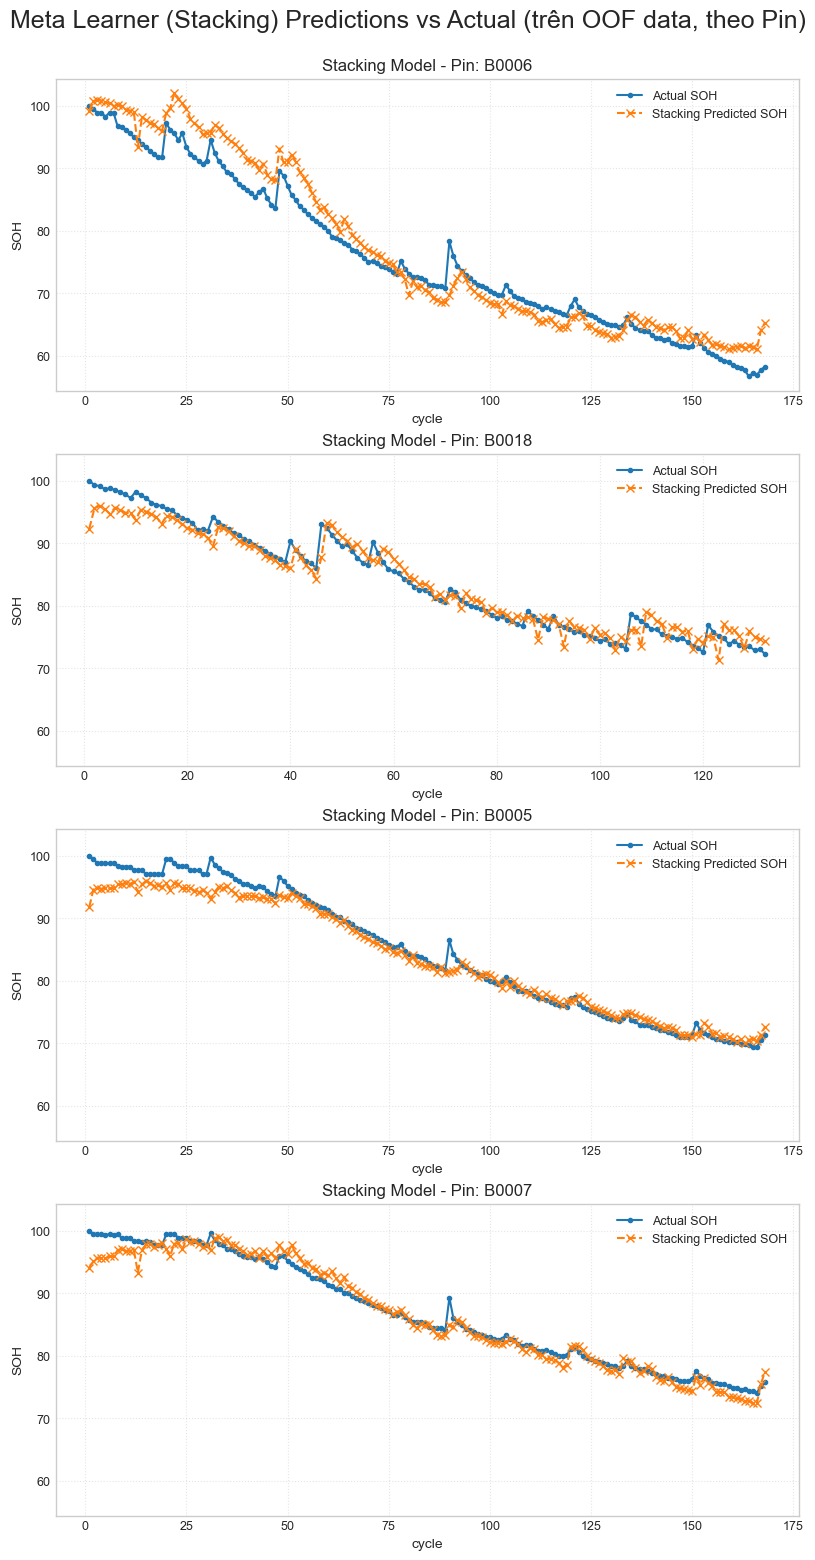

In [26]:
# Vẽ đồ thị cho meta-learner (giữ nguyên phần này vì nó hữu ích)
fig_meta_learner, axes_meta_learner = plt.subplots(n_outer_splits, 1,
                                                   figsize=(8, 15),
                                                   sharey=True, constrained_layout=True)
if n_outer_splits == 1:
    axes_meta_learner = [axes_meta_learner]
fig_meta_learner.suptitle('Meta Learner (Stacking) Predictions vs Actual (trên OOF data, theo Pin)', fontsize=18, y=1.03)
unique_batteries = groups.unique()
for i, battery_id_to_plot in enumerate(unique_batteries):
    battery_mask = (groups == battery_id_to_plot).values
    x_plot_values_batt = df_scaled[battery_mask][cycle_plot_column].values
    actual_batt = meta_target_for_training[battery_mask]
    predicted_batt_stacking = stacking_oof_predictions[battery_mask]
    # Tính R-squared
    r2 = r2_score(actual_batt, predicted_batt_stacking)

    # Tính MAE
    mae = mean_absolute_error(actual_batt, predicted_batt_stacking)

    # Tính RMSE
    rmse = mean_squared_error(actual_batt, predicted_batt_stacking, squared=False)

    print(f"R-squared: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    ax_meta = axes_meta_learner[i]
    ax_meta.plot(x_plot_values_batt, actual_batt, label='Actual SOH', marker='.', linestyle='-', markersize=6)
    ax_meta.plot(x_plot_values_batt, predicted_batt_stacking, label='Stacking Predicted SOH', marker='x', linestyle='--', markersize=6)
    ax_meta.set_title(f'Stacking Model - Pin: {battery_id_to_plot}', fontsize=12)
    ax_meta.set_xlabel(cycle_plot_column, fontsize=10)
    ax_meta.set_ylabel('SOH', fontsize=10)
    ax_meta.legend(fontsize=9)
    ax_meta.grid(True, linestyle=':', alpha=0.5)
    ax_meta.tick_params(axis='both', which='major', labelsize=9)

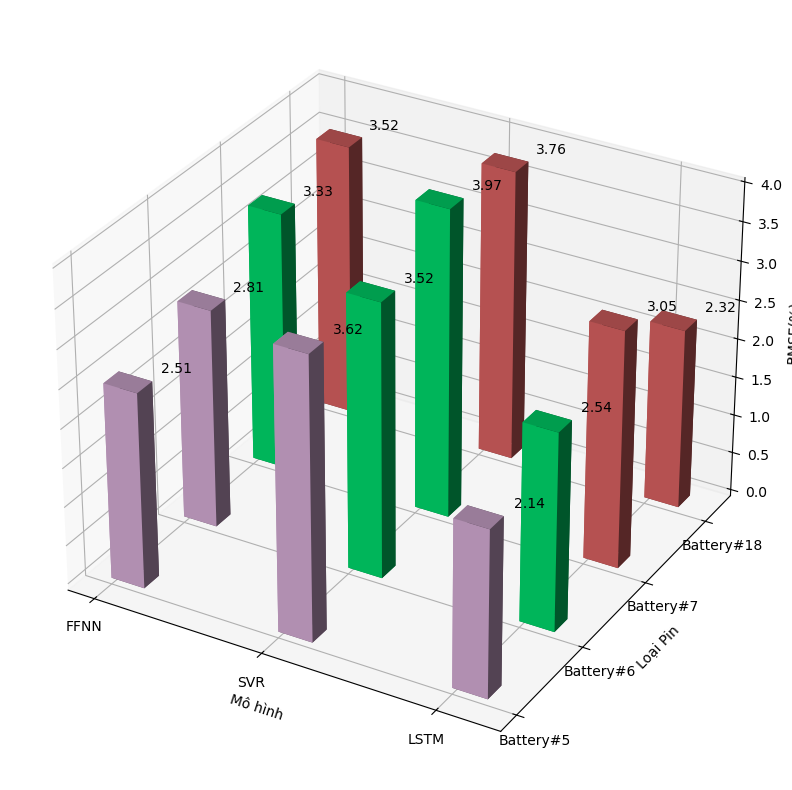

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Chuẩn bị dữ liệu ---
# Tương tự như trong ảnh của bạn
models = ['FFNN', 'SVR', 'LSTM']
batteries = ['Battery#5', 'Battery#6', 'Battery#7', 'Battery#18']

# Dữ liệu RMSE (%) - bạn hãy thay thế bằng dữ liệu của mình
# Dữ liệu được sắp xếp theo từng mô hình
data = {
    'FFNN': [2.51, 2.81, 3.33, 3.52],
    'SVR': [3.62, 3.52, 3.97, 3.76],
    'LSTM': [2.14, 2.54, 3.05, 2.32]
}

# --- 2. Thiết lập biểu đồ 3D ---
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# --- 3. Vẽ các cột ---
# Vị trí trên trục x và y
x_pos = np.arange(len(models))
y_pos = np.arange(len(batteries))

# Tạo một lưới tọa độ cho các cột
x_pos_grid, y_pos_grid = np.meshgrid(x_pos, y_pos)
x_pos_flat = x_pos_grid.flatten()
y_pos_flat = y_pos_grid.flatten()
z_pos_flat = np.zeros_like(x_pos_flat)

# Chiều cao của các cột (dữ liệu RMSE)
dz = np.array([data[model] for model in models]).T.flatten()

# Màu sắc cho mỗi mô hình
colors = ['#C8A2C8', '#00CD66', '#CD5C5C'] # Tím, Lục, Đỏ cam
bar_colors = np.repeat(colors, len(batteries))

# Vẽ biểu đồ cột 3D
# dx, dy là chiều rộng và chiều sâu của các cột
ax.bar3d(x_pos_flat, y_pos_flat, z_pos_flat, dx=0.2, dy=0.2, dz=dz, color=bar_colors)

# --- 4. Tùy chỉnh biểu đồ ---
# Đặt nhãn cho các trục
ax.set_xlabel('Mô hình')
ax.set_ylabel('Loại Pin')
ax.set_zlabel('RMSE(%)')

# Đặt các vạch chia (ticks) và nhãn cho trục x và y
ax.set_xticks(x_pos)
ax.set_xticklabels(models)
ax.set_yticks(y_pos)
ax.set_yticklabels(batteries)

# Thêm giá trị trên đỉnh mỗi cột
for i in range(len(x_pos_flat)):
    ax.text(x_pos_flat[i] + 0.3, y_pos_flat[i] + 0.3, dz[i] + 0.05, f'{dz[i]:.2f}',
            ha='center', va='bottom', color='black', fontsize=10)

# Hiển thị biểu đồ
plt.show()